In [13]:
import pandas as pd
import plotly as px
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.backends.backend_pdf import PdfPages

In [ ]:
def pattern_comportamento(df,perc_val):
    #Intervalli sul grafico 770sec, media valori ogni 30sec
    df_max =df.resample('30S').mean()
    max_value = df_max['consumption'].max()

    #if max_value==0:return "0"#0 emissioni tutto il giorno

    #ELIMINO TUTTE LE EMISSIONI INFERIORI A UNA CERTA SOGLIA
    und_value=(max_value/100)*perc_val
    for index, row in df.iterrows():
        if row['consumption'] <= und_value:
            df.at[index, 'consumption'] = 0

    df_inter =df.resample('770S').mean() #abbiamo solo emissioni 'importanti'
    
    #VEDE GLI INTERVALLI E DURATA
    count_inter = 0
    in_interval = False
    start_date = None
    end_date = None
    duration=0
    intervals = []
    for date, consumption in df_inter['consumption'].items():
        if consumption > 0:#abbiamo delle emissioni
            if not in_interval:#inizio intervallo
                in_interval = True
                start_date = date
                duration = 1 
                count_inter += 1
            else:#continuo intervallo
                duration += 1
        else:#no emissioni
            if in_interval:
                in_interval = False
                end_date=date
                intervals.append((start_date, end_date, duration))    
    if in_interval:
        end_date=date
        intervals.append((start_date, end_date, duration))
    print('DEBUG ARRAY INTERVALLI\n')
    print(intervals)

    #un intervallo vale 770s=12,8m
    #CREAZIONE PATTERN
    count_intervalli=len(intervals)
    pattern=""
    #if count_intervalli>3: pattern += "5"#MOLTE EMISSIONI
    #else: pattern += str(count_intervalli) #1,2,3 

    pattern += str(count_intervalli)

    #AGGIUNTA SULL'ANANLISI PER MENO DI 4 INTERVALLI
    if count_intervalli<=3:
        for date_inizio,date_fine, durata in intervals:
            if durata>3: pattern += "L"#INTERVALLO LUNGO
            elif durata>1:  pattern += "M"#INTERVALLO MEDIO
            else: pattern += "P"#INTERVALLO PICCOLO     

    pattern += "_"   
    
    #CREAZIONE ARRAY CON DATA INIZIO E FINE PER FUTURI CALCOLI
    diff_tra_intervalli = []
    dates = [(interval[0]).to_pydatetime() for interval in intervals]#array inizio intervalli
    dates_fine = [(interval[1]).to_pydatetime() for interval in intervals]#array fine intervalli
    
    #CALCOLA TIPI DI INTERVALLI TRA I MOMENTI DI USO DEL DISPOSITIVO
    for i in range(len(dates_fine) - 1):
        difference  = (dates[i+1] - dates_fine[i]).total_seconds()
        diff=difference/770
        diff_tra_intervalli.append(diff)
    print(f'\nspazio tra gli intervalli: {diff_tra_intervalli}\n')
    count_l=0
    count_m=0
    count_p=0
    for x in diff_tra_intervalli:#calcolo dei tipi di intervalli
        if x>3: count_l += 1#intervallo di tempo LUNGO
        elif x>1:  count_m += 1#intervallo di tempo MEDIO
        else: count_p += 1#intervallo di tempo PICCOLO

    #ANALISI GENERALE INTERVALLI
    if count_l==len(dates): pattern+="S0"#MOLTO MOLTO SPARSO
    elif count_l>=(3/4)*len(dates):#MOLTO SPARSO
        if count_m>=(3/4)*count_p: pattern+="S1a"
        elif count_m>=(1/2)*count_p: pattern+="S1b"
        elif count_m>=(1/4)*count_p: pattern+="S1c"
        elif count_m==0: pattern+="S1d"
    elif count_l>=(1/2)*len(dates):#SPARSO
        if count_m>=(3/4)*count_p: pattern+="S2a"
        elif count_m>=(1/2)*count_p: pattern+="S2b"
        elif count_m>=(1/4)*count_p: pattern+="S2c"
        elif count_m==0: pattern+="S2d"
    elif count_l>=(1/4)*len(dates):#MEDIAMENTE SPARSO
        if count_m>=(3/4)*count_p: pattern+="M1a"
        elif count_m>=(1/2)*count_p: pattern+="M1b"
        elif count_m>=(1/4)*count_p: pattern+="M1c"
        elif count_m==0: pattern+="M1d"
    elif count_l==0:#NON MOLTO SPARSO
        if count_m>=(3/4)*count_p: pattern+="M2a"
        elif count_m>=(1/2)*count_p: pattern+="M2b"
        elif count_m>=(1/4)*count_p: pattern+="M2c"
        elif count_m==0: pattern+="P1" #CONCENTRATO
    return pattern

    #logica
    #if x>=(3/4)*y:
    #elif x>=(1/2)*y:
    #elif x>=(1/4)*y:
    #elif x==0:

In [ ]:
def range_plot_media(df,date,perc_val):
    #Media delle emissioni degli intervalli di X secondi
    df=df.resample('30S').mean()
    max_value = df['consumption'].max()

    #if max_value==0:return
    #ELIMINO TUTTE LE EMISSIONI INFERIORI A UNA CERTA SOGLIA
    und_value=(max_value/100)*perc_val
    for index, row in df.iterrows():
        if row['consumption'] <= und_value:
            df.at[index, 'consumption'] = 0

    plt.figure(figsize=(10, 6))

    #Grafico per tutte le emissioni
    plt.plot(df.index, df['consumption'], label={'consumption': 'VolumeMedia [L]'}, color='red', linewidth=0.5)

    #Formatta le date sull'asse x
    plt.gca().xaxis.set_major_locator(mdates.SecondLocator(interval=770))

    #Tick per i giorni con colore differenti
    plt.gca().xaxis.set_minor_formatter(mdates.DateFormatter('%m-%d'))
    plt.gca().xaxis.set_minor_locator(mdates.DayLocator(interval=1))
    plt.tick_params(axis='x', which='minor', colors='red')

    # Impostazioni dell'asse y con tick ogni 100 unità
    plt.gca().yaxis.set_major_locator(plt.MultipleLocator(100))
    max_value = df['consumption'].max()
    if max_value>1000:
        plt.gca().yaxis.set_minor_locator(plt.MultipleLocator(50))
    else:
        plt.gca().yaxis.set_minor_locator(plt.MultipleLocator(20))

    #Impostazioni della griglia
    plt.xlabel('Date')
    plt.ylabel('Consumption (L)')
    plt.title(f'Emissioni del giorno {date}')
    plt.legend()
    plt.grid(True, which='major', linestyle='-', linewidth=1)
    plt.grid(True, which='minor', linestyle='-', linewidth=5)
    plt.grid(True, which='major', axis='y', linestyle='-', linewidth=1)
    plt.grid(True, which='minor', axis='y', linestyle='-', linewidth=1)
    plt.xticks(rotation=90)
    plt.show() #X CONTROLLI GRAFIIC

    # Chiudere il grafico per liberare memoria
    plt.close()

In [ ]:
def pattern_comportamento_test(df,day_emiss,mm,mt,ms):
    #Intervalli sul grafico 770sec=12,8m, media valori ogni 30sec

    df_inter =df.resample('770S').mean() #abbiamo solo emissioni 'importanti'
    
    #VEDE GLI INTERVALLI E DURATA
    in_interval = False
    start_date = None
    end_date = None
    duration=0
    intervals = []
    for date, consumption in df_inter['consumption'].items():
        if consumption > 0:#abbiamo delle emissioni
            if not in_interval:#inizio intervallo
                in_interval = True
                start_date = date
                duration = 1 
            else:#continuo intervallo
                duration += 1
        else:#no emissioni
            if in_interval:
                in_interval = False
                end_date=date
                intervals.append((start_date, end_date, duration))    
    if in_interval:
        end_date=date
        intervals.append((start_date, end_date, duration))
    #DEBUG print(intervals)

    #CREAZIONE PATTERN
    #ANALISI EMISSIONI 
    print(f'{day_emiss }')
    #mm
    pattern=""
    if day_emiss<(mm/4):
        pattern+= "CA"
    elif day_emiss<(mm/2):
        pattern+= "CB"
    elif day_emiss<(mm*(3/4)):
        pattern+= "CC"
    elif day_emiss<mm:
        pattern+= "CD"
    elif day_emiss<(mm*(5/4)):
        pattern+= "CE"
    elif day_emiss<(mm*(3/2)):
        pattern+= "CF"
    elif day_emiss<(mm*(7/4)):
        pattern+= "CG"
    else:
        pattern+= "CH"
        
    #mt
    if day_emiss<(mt/4):
        pattern+= "MA"
    elif day_emiss<(mt/2):
        pattern+= "MB"
    elif day_emiss<(mt*(3/4)):
        pattern+= "MC"
    elif day_emiss<mt:
        pattern+= "MD"
    elif day_emiss<(mt*(5/4)):
        pattern+= "ME"
    elif day_emiss<(mt*(3/2)):
        pattern+= "MF"
    elif day_emiss<(mt*(7/4)):
        pattern+= "MG"
    else:
        pattern+= "MH"

    #ms
    if day_emiss<(ms / 4):
        pattern+= "LA"
    elif day_emiss<(ms / 2):
        pattern+= "LB"
    elif day_emiss<(ms * (3 / 4)):
        pattern+= "LC"
    elif day_emiss<ms:
        pattern+= "LD"
    elif day_emiss<(ms * (5 / 4)):
        pattern+= "LE"
    elif day_emiss<(ms * (3 / 2)):
        pattern+= "LF"
    elif day_emiss<(ms * (7 / 4)):
        pattern+= "LG"
    else:
        pattern+= "LH"
    
    #ANALISI INTERVALLI
    count_intervalli=len(intervals)
    pattern+= str(count_intervalli) #NUMERO DI INTERVALLI 

    #AGGIUNTA SULL'ANANLISI PER MENO DI 4 INTERVALLI
    if count_intervalli<4:#osservazione potrei farlo per tutti o allargare il numero 
        for _,_, durata in intervals:
            if durata>3: pattern += "L"#INTERVALLO LUNGO
            elif durata>1:  pattern += "M"#INTERVALLO MEDIO
            else: pattern += "P"#INTERVALLO PICCOLO     

    pattern += "_"   
    
    #CHANGE
    count_l=0
    count_m=0
    count_p=0
    for i in range(len(intervals) - 1):
        ris=int(( (intervals[i+1][0]).to_pydatetime() - (intervals[i][1]).to_pydatetime() ).total_seconds()/770)
        if ris>3: count_l += 1#intervallo di tempo LUNGO
        elif ris>1:  count_m += 1#intervallo di tempo MEDIO
        else: count_p += 1#intervallo di tempo PICCOLO
        #diff_tra_intervalli.append(  ris )

    tot=count_l+(count_m+count_p)
    #ANALISI GENERALE INTERVALLI
    if count_l==tot: pattern+="S0"#MOLTO MOLTO SPARSO
    elif count_l>=(3/4)*tot:#MOLTO SPARSO
        if count_m==(count_m+count_p): pattern+="S1a"
        elif count_m>=(3/4)*(count_m+count_p): pattern+="S1b"
        elif count_m>=(1/2)*(count_m+count_p): pattern+="S1c"
        elif count_m>=(1/4)*(count_m+count_p): pattern+="S1d"
        elif count_m>0: pattern+="S1e"
        elif count_m==0: pattern+="S1f"
    elif count_l>=(1/2)*tot:#SPARSO
        if count_m==(count_m+count_p): pattern+="S2a"
        elif count_m>=(3/4)*(count_m+count_p): pattern+="S2b"
        elif count_m>=(1/2)*(count_m+count_p): pattern+="S2c"
        elif count_m>=(1/4)*(count_m+count_p): pattern+="S2d"
        elif count_m>0: pattern+="S2e"
        elif count_m==0: pattern+="S2f"
    elif count_l>=(1/4)*tot:#MEDIAMENTE SPARSO
        if count_m==(count_m+count_p): pattern+="M1a"
        elif count_m>=(3/4)*(count_m+count_p): pattern+="M1b"
        elif count_m>=(1/2)*(count_m+count_p): pattern+="M1c"
        elif count_m>=(1/4)*(count_m+count_p): pattern+="M1d"
        elif count_m>0: pattern+="M1e"
        elif count_m==0: pattern+="M1f"
    elif count_l>0:#NON MOLTO SPARSO
        if count_m==(count_m+count_p): pattern+="M2a"
        elif count_m>=(3/4)*(count_m+count_p): pattern+="M2b"
        elif count_m>=(1/2)*(count_m+count_p): pattern+="M2c"
        elif count_m>=(1/4)*(count_m+count_p): pattern+="M2d"
        elif count_m>0: pattern+="M2e"
        elif count_m==0: pattern+="P0" #CONCENTRATO
    elif count_l==0:#NON MOLTO SPARSO
        if count_m==(count_m+count_p): pattern+="P1a"
        elif count_m>=(3/4)*(count_m+count_p): pattern+="P1b"
        elif count_m>=(1/2)*(count_m+count_p): pattern+="P1c"
        elif count_m>=(1/4)*(count_m+count_p): pattern+="P1d"
        elif count_m>0: pattern+="P1e"
        elif count_m==0: pattern+="P1f" #CONCENTRATO
    print("DEBUG")
    return pattern

In [10]:
def calcola_media_mensile(df):
    periodi_mensili = [
        (pd.Timestamp('2019-01-01'), pd.Timestamp('2019-01-31')),
        (pd.Timestamp('2019-02-01'), pd.Timestamp('2019-02-28')),
        (pd.Timestamp('2019-03-01'), pd.Timestamp('2019-03-31')),
        (pd.Timestamp('2019-04-01'), pd.Timestamp('2019-04-30')),
        (pd.Timestamp('2019-05-01'), pd.Timestamp('2019-05-31')),
        (pd.Timestamp('2019-06-01'), pd.Timestamp('2019-06-30')),
        (pd.Timestamp('2019-07-01'), pd.Timestamp('2019-07-31')),
        (pd.Timestamp('2019-08-01'), pd.Timestamp('2019-08-31')),
        (pd.Timestamp('2019-09-01'), pd.Timestamp('2019-09-30')),
        (pd.Timestamp('2019-10-01'), pd.Timestamp('2019-10-31')),
        (pd.Timestamp('2019-11-01'), pd.Timestamp('2019-11-30')),
        (pd.Timestamp('2019-12-01'), pd.Timestamp('2019-12-31'))
    ]

    # Calcolare la media per ciascun periodo
    media_mensile = []
    for start, end in periodi_mensili:
        media = df.loc[start:end].mean()
        media_mensile.append(media.values[0])  # Assumendo che ci sia una sola colonna di valori

    return media_mensile

In [9]:
def calcola_media_trimestrale(df):
    periodi_trimestrali = [
        (pd.Timestamp('2019-01-01'), pd.Timestamp('2019-03-31')),
        (pd.Timestamp('2019-04-01'), pd.Timestamp('2019-06-30')),
        (pd.Timestamp('2019-07-01'), pd.Timestamp('2019-09-30')),
        (pd.Timestamp('2019-10-01'), pd.Timestamp('2019-12-31'))
    ]

    # Calcolare la media per ciascun periodo
    media_trimestrale = []
    for start, end in periodi_trimestrali:
        media = df.loc[start:end].mean()
        media_trimestrale.append(media.values[0])  # Assumendo che ci sia una sola colonna di valori

    return media_trimestrale

In [8]:
def calcola_media_semestrale(df_final):
    periodi_semestrali = [
        (pd.Timestamp('2019-01-01'), pd.Timestamp('2019-06-30')),
        (pd.Timestamp('2019-07-01'), pd.Timestamp('2019-12-31'))
    ]
    media_semestrale = []
    for start, end in periodi_semestrali:
        media = df_final.loc[start:end].mean()
        media_semestrale.append(media.values[0])  # Assumendo che ci sia una sola colonna di valori

    return media_semestrale

In [7]:
def calcola_media_annuale(df):
    return df['consumption'].mean()

In [6]:
def read_fixture_sec(fixture: str, rule='S'):
    # Legge il CSV
    df = pd.read_csv(f'./data/feed_{fixture}.MYD.csv', delimiter=' ', header=None, names=['date', fixture])
    df['date'] = pd.to_datetime(df['date'], unit='s')
    
    # Rinomina la colonna fixture in 'consumption'
    df.rename(columns={fixture: 'consumption'}, inplace=True)
    df.set_index('date', inplace=True)
    
    # Resample il DataFrame usando la frequenza specificata (secondi 'S')
    df_secondly = df.resample(rule).sum()
    
    # Creare un DataFrame vuoto con il range di date specificato a livello di secondi
    date_rng = pd.date_range(start='2019-01-01', end='2019-12-31 23:59:59', freq='S')
    df_final = pd.DataFrame(date_rng, columns=['date'])
    df_final.set_index('date', inplace=True)
    
    # Unire il DataFrame secondario con il DataFrame vuoto per assicurarsi che tutte le date siano presenti
    df_final = df_final.join(df_secondly, how='left').fillna(0)
    
    return df_final

In [5]:
def read_fixture(fixture: str, rule='T'):
    #Legge CSV
    df = pd.read_csv(f'./data/feed_{fixture}.MYD.csv', delimiter=' ', header=None, names=['date', fixture])
    df['date'] = pd.to_datetime(df['date'], unit='s')
    
    # Rinomina la colonna fixture in 'consumption'
    df.rename(columns={fixture: 'consumption'}, inplace=True)
    df.set_index('date', inplace=True)
    
    # Resample il DataFrame usando la frequenza specificata (minutale 'T')
    df_minutely = df.resample(rule).sum()
    
    # Ora raggruppiamo i dati minutali in giornate
    df_daily = df_minutely.resample('D').sum()

    # Creare un DataFrame vuoto con il range di date specificato
    date_rng = pd.date_range(start='2019-01-01', end='2019-12-31' , freq='D')
    df_final = pd.DataFrame(date_rng, columns=['date'])
    df_final.set_index('date', inplace=True)
    
    # Unire il DataFrame giornaliero con il DataFrame vuoto per assicurarsi che tutte le date siano presenti
    df_final = df_final.join(df_daily, how='left').fillna(0)
    
    return df_final

In [ ]:
from collections import Counter
#per vedere le differenze basta che cambi perc_val o eliminare la parte di codice tra gli asterisci

df_dispositivo_sec=read_fixture_sec('Washbasin')
df_dispositivo_emissioni=read_fixture('Washbasin')
diz_patterns = {}
dizionario_pattern = {}
perc_val=5 #CAMBIARE IL VALORE PER AUMENTARE/DIMINUIRE IL MINIMO ACCETTABILE PER OGNI INTERVALLO

start_date = pd.Timestamp('2019-01-07')#PRIMO LUNEDI 
end_date = pd.Timestamp('2019-12-29')#ULTIMA DOMENICA 
date_rng = pd.date_range(start= start_date, end=end_date, freq='D')

#CALCOLI DELLA MEDIA MENSILE, TRIMESTRALE, SEMESTRALE
mm_array=calcola_media_mensile(df_dispositivo_emissioni)
mt_array=calcola_media_trimestrale(df_dispositivo_emissioni)
ms_array=calcola_media_semestrale(df_dispositivo_emissioni)
ma=calcola_media_annuale(df_dispositivo_emissioni)
#DEBUG 
#print(f'Media MENSILE: {mm_array}\n')
#print(f'Media TRIMESTRALE: {mt_array}\n')
#print(f'Media SEMESTRALE: {ms_array}\n')
#print(f'Media ANNUALE: {ma}\n')

for date in date_rng:
    #print(f'{date}\n')
    start_date = pd.Timestamp(date)
    end_date = pd.Timestamp(date).replace(hour=23, minute=59, second=59)
    patterns=""

    #CAPISCE ALGORTIMO
    df= df_dispositivo_sec[start_date:end_date]
    df_dispositivo_emis=df_dispositivo_emissioni[start_date:end_date] #calcoli su emissioni

    #***********CONTROLLA SE SUPERIAMO LO 0.1% DELLA MEDIA ANNUALE DI EMISSIONI NELLA GIORNATA 
    day_emiss=df_dispositivo_emis['consumption'].to_numpy()
    day_emiss=day_emiss[0]
    temp=(ma/100)*0.1
    if day_emiss<temp: patterns="0"
    else:
    #**********
        df_max =df.resample('30S').mean()
        max_value = df_max['consumption'].max()
        und_value=(max_value/100)*perc_val
        #ELIMINO TUTTE LE EMISSIONI INFERIORI A UNA CERTA SOGLIA
        for index, row in df.iterrows():
            if row['consumption'] < und_value:
                df.at[index, 'consumption'] = 0
        
        if max_value!=0:
            #GRAFICI range_plot_media(df,start_date,perc_val)
            
            #VALORI MEDIE IN BASE AL GIORNO
            num_mese=date.month
            #mensile
            mm=mm_array[num_mese-1]
            #trimestrale
            if num_mese<=3: mt=mt_array[0]
            elif num_mese<=6: mt=mt_array[1]
            elif num_mese<=9: mt=mt_array[2]
            else: mt=mt_array[3]
            #semestrale
            if num_mese<=6: ms=ms_array[0]
            else: ms=ms_array[1]

            patterns=pattern_comportamento_test(df,day_emiss,mm,mt,ms)
        else: patterns="0"  
    #DEBUG print(f'Pattern grafico {patterns}\n')

    #CODICE PER OTTENERE LE VOLTE CHE UN PATTERN SI PRESENTA
    #Calcola presenze dei pattern
    if patterns in diz_patterns:#se lo trova 
        dizionario_pattern[patterns].append(df_max)
        diz_patterns[patterns] += 1
    else:
        dizionario_pattern[patterns]=[]
        dizionario_pattern[patterns].append(df_max)
        diz_patterns[patterns] = 1
    #CARTELLA DOVE SALVARE I GRAFICI patterngrafico
print(f'Numero di chiavi nel dizionario: {len(diz_patterns)}:{len(dizionario_pattern)}')
print(diz_patterns)
for key,value in dizionario_pattern.items():
        print(f'\n{key}')
        pdf_filename = f'patterngrafico\{key}.pdf'
        with PdfPages(pdf_filename) as pdf:
            for graf in value:
                # Stampa l'oggetto Figure 
                if not isinstance(graf, pd.DataFrame) or 'consumption' not in graf.columns:#CONTROLLO 
                    print(f'Warning: Invalid DataFrame for key {key}')
                    continue

                #Media delle emissioni degli intervalli di X secondi
                df=graf.resample('30S').mean()

                plt.figure(figsize=(10, 6))

                #Grafico per tutte le emissioni
                plt.plot(df.index, df['consumption'], label={'consumption': 'VolumeMedia [L]'}, color='red', linewidth=0.5)

                #Formatta le date sull'asse x
                plt.gca().xaxis.set_major_locator(mdates.SecondLocator(interval=770))

                #Tick per i giorni con colore differenti
                plt.gca().xaxis.set_minor_formatter(mdates.DateFormatter('%m-%d'))
                plt.gca().xaxis.set_minor_locator(mdates.DayLocator(interval=1))
                plt.tick_params(axis='x', which='minor', colors='red')

                # Impostazioni dell'asse y con tick ogni 100 unità
                plt.gca().yaxis.set_major_locator(plt.MultipleLocator(100))
                max_value = df['consumption'].max()
                if max_value>1000:
                    plt.gca().yaxis.set_minor_locator(plt.MultipleLocator(50))
                else:
                    plt.gca().yaxis.set_minor_locator(plt.MultipleLocator(20))
                plt.tick_params(axis='y', which='minor', colors='red')


                #Impostazioni della griglia
                plt.xlabel('Date')
                plt.ylabel('Consumption (L)')
                plt.title(f'Emissioni del pattern {key}')
                plt.legend()
                plt.grid(True, which='major', linestyle='-', linewidth=1)
                plt.grid(True, which='minor', linestyle='-', linewidth=5)
                plt.grid(True, which='major', axis='y', linestyle='-', linewidth=1)
                plt.grid(True, which='minor', axis='y', linestyle='-', linewidth=1)
                plt.xticks(rotation=90)

                pdf.savefig() #X CONTROLLI GRAFIIC

                # Chiudere il grafico per liberare memoria
                plt.close()
        #print(f'Fine per {key}')


In [ ]:
#verifica sulle intensita delle emissioni
df_dispositivo_emissioni=read_fixture('Washbasin')
#CALCOLI DELLA MEDIA MENSILE, TRIMESTRALE, SEMESTRALE
mm_array=calcola_media_mensile(df_dispositivo_emissioni)
mt_array=calcola_media_trimestrale(df_dispositivo_emissioni)
ms_array=calcola_media_semestrale(df_dispositivo_emissioni)
ma=calcola_media_annuale(df_dispositivo_emissioni)
#DEBUG 
print(f'Media MENSILE: {mm_array}\n')
print(f'Media TRIMESTRALE: {mt_array}\n')
print(f'Media SEMESTRALE: {ms_array}\n')
print(f'Media ANNUALE: {ma}\n')
temp=(ma/100)*0.1
print(f'errore: {temp}\n')

date=[('2019-02-13') ,('2019-06-01'),('2019-08-14'),('2019-03-18'),('2019-04-24'),('2019-04-25'),('2019-02-22'),('2019-07-14')
        ,('2019-03-19'),('2019-03-20'),('2019-04-06'),('2019-05-24'),('2019-04-11'),('2019-05-29'),('2019-04-16'),('2019-04-26') 
        ,('2019-05-18'),('2019-06-14'),('2019-05-27'),('2019-09-01'),
        ('2019-09-23'),('2019-09-24'),('2019-10-22'),('2019-10-26'),('2019-04-14'),('2019-04-21'),('2019-04-30'),('2019-07-19'),('2019-09-08')]
for day in date:
    #print(f'{date}\n')
    start_date = pd.Timestamp(day)
    end_date = pd.Timestamp(day).replace(hour=23, minute=59, second=59)

    #CAPISCE ALGORTIMO
    df= df_dispositivo_emissioni[start_date:end_date]
    day_emiss=df['consumption'].to_numpy()
    day_emiss=day_emiss[0]
    print(f'{start_date}[{day_emiss}]\n')

In [ ]:
diz={'0': 125, 'CAMALA1P_S0': 2, 'CCMDLB3PMM_S2f': 1, 'CHMHLH4_S0': 1, 'CGMHLF3MPP_S0': 1, 'CHMHLG2LM_S0': 1, 'CHMHLH8_S2c': 1, 'CFMHLE5_S1a': 1, 'CHMHLH9_S2a': 2, 'CGMHLE5_S0': 1, 'CFMGLD3MPP_S2f': 1, 'CHMHLG5_S1a': 1, 'CHMHLH8_M1c': 1, 'CGMHLE3LMP_S0': 1, 'CHMHLH6_M1d': 1, 'CEMHLE4_S2a': 1, 'CDMGLD5_S1f': 1, 'CFMHLF5_S2a': 2, 'CFMHLF2MP_S0': 1, 'CDMGLD3PPL_S0': 1, 'CCMDLC3MMP_S2a': 1, 'CCMDLC1M_S0': 1, 'CDMFLC3PPL_P1c': 1, 'CFMHLF7_S2f': 1, 'CAMBLA2PP_P1a': 1, 'CEMGLD3MPP_S2f': 1, 'CDMFLC5_S1f': 1, 'CEMHLE8_S2f': 1, 'CDMGLD3PPM_S0': 1, 'CAMALA1M_S0': 3, 'CDMGLD4_S0': 2, 'CDMGLD3LPP_S0': 1, 'CDMGLD13_M1d': 1, 'CEMHLE3PLM_S0': 1, 'CHMHLH8_S1a': 1, 'CDMFLD2MP_S0': 1, 'CHMHLH8_S2a': 1, 'CCMDLC2MM_S0': 1, 'CFMHLE8_S0': 1, 'CCMDLC2MP_S0': 1, 'CCMDLC2PP_S0': 1, 'CCMDLC2LP_S0': 1, 'CHMHLH3MPP_S0': 1, 'CBMBLC2PL_P1a': 1, 'CCMCLD1M_S0': 1, 'CDMCLE3MMM_S0': 1, 'CEMELF7_S2d': 1, 'CDMCLD5_S1f': 2, 'CFMELH2MM_S0': 1, 'CBMBLB7_S1a': 1, 'CCMBLC3MMM_S2f': 1, 'CBMBLC2MP_S0': 2, 'CEMELG6_S0': 1, 'CFMELH5_S0': 1, 'CAMALA2PP_S0': 5, 'CEMDLF5_S2a': 1, 'CDMDLE7_S2c': 2, 'CEMELF5_M1f': 1, 'CHMHLH3PMP_S2f': 1, 'CBMALB5_M1c': 1, 'CDMDLE7_S2f': 1, 'CFMFLH6_S0': 1, 'CHMHLH9_M1b': 1, 'CHMGLH7_S2c': 1, 'CCMCLD7_S2c': 1, 'CCMCLD2MM_P1f': 1, 'CHMHLH6_S1a': 1, 'CCMBLC4_S0': 1, 'CDMCLD4_M1c': 1, 'CFMDLF6_S2f': 1, 'CCMBLC2PL_S0': 1, 'CDMCLE6_S2a': 1, 'CDMCLD3MPM_S0': 1, 'CEMDLE4_S2a': 1, 'CCMCLD4_S2a': 1, 'CCMCLD2MP_P1f': 1, 'CAMALA3PPP_S2a': 1, 'CDMCLE5_S1f': 1, 'CEMDLF4_S2f': 1, 'CDMCLD1L_S0': 1, 'CDMCLD4_S2f': 1, 'CHMHLH6_S2c': 2, 'CCMCLD9_S2c': 1, 'CBMBLB2PP_S0': 1, 'CGMFLH5_S1a': 1, 'CFMELG4_M1f': 1, 'CGMELG4_S2f': 1, 'CFMELG4_S2f': 1, 'CAMALA4_S2a': 2, 'CDMCLE1M_S0': 1, 'CHMFLH5_M1d': 1, 'CDMELG7_S1f': 1, 'CDMFLH7_M1b': 1, 'CDMFLH8_S1a': 1, 'CBMCLD4_S2a': 1, 'CCMDLF4_S2a': 1, 'CCMDLF9_S2c': 1, 'CBMCLD7_S1f': 1, 'CBMCLD8_S1a': 1, 'CFMHLH12_S2c': 1, 'CBMBLB4_S2f': 1, 'CEMFLH9_S2c': 1, 'CEMGLH8_M1c': 1, 'CHMHLH10_M1b': 1, 'CBMCLD7_S1a': 1, 'CCMDLF7_M1b': 1, 'CCMDLE4_S0': 1, 'CHMHLH11_M2d': 1, 'CBMBLC3MMM_P1c': 1, 'CEMFLH16_M1d': 1, 'CEMFLH11_S2c': 1, 'CBMCLD5_S1f': 1, 'CCMDLF2LM_S0': 1, 'CEMGLH11_S2d': 1, 'CCMCLE11_M2c': 1, 'CAMALA5_M1d': 1, 'CAMALA4_S0': 1, 'CDMELG8_S2a': 1, 'CEMELF1L_S0': 1, 'CAMBLB3MPP_S2a': 1, 'CEMFLG9_S1c': 1, 'CCMCLD2LM_S0': 1, 'CAMALA2MP_S0': 1, 'CHMHLH11_M1a': 1, 'CDMELF7_S1a': 1, 'CFMGLH4_S2a': 1, 'CDMDLE3PLP_S0': 1, 'CGMHLH13_S2d': 1, 'CCMDLD4_S2f': 1, 'CHMHLH11_S2a': 1, 'CEMELF2MP_P1f': 1, 'CDMDLE4_S2a': 1, 'CHMHLH10_S2c': 1, 'CCMCLD4_S2f': 1, 'CCMCLD8_S2c': 1, 'CCMDLD4_M1a': 1, 'CDMELF7_M1d': 1, 'CDMELF4_M1f': 1, 'CDMDLE5_S2c': 1, 'CAMALA5_S2a': 1, 'CCMDLD4_M1c': 1, 'CEMFLG6_S0': 1, 'CEMELF9_S1f': 1, 'CDMDLE7_M1b': 1, 'CFMGLH10_S1c': 1, 'CDMELF2PM_P1f': 1, 'CHMDLE6_M1d': 1, 'CHMHLH16_M1c': 1, 'CDMBLC5_S0': 1, 'CDMBLC1M_S0': 1, 'CCMBLB1P_S0': 1, 'CGMDLE4_S2f': 1, 'CDMBLC3PLP_S2a': 1, 'CFMDLD6_S2a': 1, 'CFMDLD10_M1e': 1, 'CCMBLB2PM_P1a': 1, 'CEMCLC4_P1c': 1, 'CHMFLH3LPP_P1c': 1, 'CDMBLB1M_S0': 1, 'CHMHLH2MP_S0': 1, 'CAMALA2MP_P1a': 1, 'CEMCLD4_S2a': 1, 'CHMHLH6_S2a': 1, 'CDMELF3MPM_S0': 1, 'CBMCLD5_S0': 1, 'CEMGLH10_S2b': 1, 'CDMELF5_S1a': 1, 'CBMCLC4_S2f': 1, 'CCMCLD3PPM_P1a': 1, 'CCMDLE2MM_S0': 1, 'CGMHLH4_S2f': 1, 'CBMCLC2PP_P1a': 1, 'CCMDLE5_S2c': 1, 'CGMHLH7_S2c': 1, 'CAMBLB3PPP_S0': 1, 'CCMCLD2MP_P1a': 1, 'CGMHLH10_M1d': 1, 'CEMGLH11_M1d': 1, 'CEMGLH6_M1a': 1, 'CDMELF2MM_S0': 1, 'CGMHLH8_S2a': 1, 'CCMDLE3PMP_S2f': 1, 'CHMHLH7_S1f': 2, 'CHMHLH8_S2f': 1, 'CFMHLH4_S2f': 1, 'CCMDLE6_S1a': 1, 'CHMHLH5_S0': 1, 'CGMHLH9_S1c': 1, 'CGMHLH8_M1a': 1, 'CEMFLH8_S2c': 1, 'CEMHLH4_S0': 1, 'CAMALA3MMP_P1c': 1, 'CBMELD2MM_S0': 1, 'CGMHLH6_M1c': 1, 'CDMHLH8_S1a': 1, 'CHMHLH4_S2a': 1, 'CBMFLE5_S0': 1, 'CHMHLH6_S1f': 1, 'CEMHLH3MPM_S2f': 1, 'CBMFLE3MPP_S2f': 1, 'CHMHLH10_S2d': 1, 'CHMHLH9_S1a': 1, 'CHMHLH5_S1a': 1, 'CCMHLG5_S1f': 1, 'CCMGLE3MPP_S0': 1, 'CCMHLG4_S0': 1, 'CCMHLG5_M1d': 1, 'CHMHLH8_M1d': 1, 'CAMCLC2PP_S0': 1, 'CBMDLC2PP_S0': 1, 'CEMHLH6_S0': 2, 'CBMFLE3LPP_S2f': 1, 'CCMHLG3LMP_S0': 1, 'CDMHLH4_S0': 1, 'CGMHLH6_S1a': 1, 'CFMHLH10_M1a': 1}

new_diz={}
for key,value in diz.items():
    if value in new_diz:#se lo trova 
        new_diz[value].append(key)
    else:
        new_diz[value]=[]
        new_diz[value].append(key)

for key,value in new_diz.items():
    print(f'{key}:\t{new_diz[key]}\n')


In [ ]:
#MAIN PER STAMPARE I PATTERN IN SETTIMANE

In [38]:
def scelta_pattern(df_final_sec,day_emiss,mm,mt,ms,num):
    #Intervalli sul grafico 770sec=12,8m, media valori ogni 30sec

    df_inter =df_final_sec.resample('770S').mean() #abbiamo solo emissioni 'importanti'
    
    #VEDE GLI INTERVALLI E DURATA
    in_interval = False
    start_date = None
    end_date = None
    duration=0
    intervals = []
    for date, consumption in df_inter['consumption'].items():
        if consumption > 0:#abbiamo delle emissioni
            if not in_interval:#inizio intervallo
                in_interval = True
                start_date = date
                duration = 1 
            else:#continuo intervallo
                duration += 1
        else:#no emissioni
            if in_interval:
                in_interval = False
                end_date=date
                intervals.append((start_date, end_date, duration))    
    if in_interval:
        end_date=date
        intervals.append((start_date, end_date, duration))
    #DEBUG print(intervals)

    #CREAZIONE PATTERN
    #ANALISI EMISSIONI 
    #print(f'{day_emiss }')
    #mm
    pattern=""
    if day_emiss<(mm/4):
        pattern+= "CA"
    elif day_emiss<(mm/2):
        pattern+= "CB"
    elif day_emiss<(mm*(3/4)):
        pattern+= "CC"
    elif day_emiss<mm:
        pattern+= "CD"
    elif day_emiss<(mm*(5/4)):
        pattern+= "CE"
    elif day_emiss<(mm*(3/2)):
        pattern+= "CF"
    elif day_emiss<(mm*(7/4)):
        pattern+= "CG"
    else:
        pattern+= "CH"
        
    #mt
    if day_emiss<(mt/4):
        pattern+= "MA"
    elif day_emiss<(mt/2):
        pattern+= "MB"
    elif day_emiss<(mt*(3/4)):
        pattern+= "MC"
    elif day_emiss<mt:
        pattern+= "MD"
    elif day_emiss<(mt*(5/4)):
        pattern+= "ME"
    elif day_emiss<(mt*(3/2)):
        pattern+= "MF"
    elif day_emiss<(mt*(7/4)):
        pattern+= "MG"
    else:
        pattern+= "MH"

    #ms
    if day_emiss<(ms / 4):
        pattern+= "LA"
    elif day_emiss<(ms / 2):
        pattern+= "LB"
    elif day_emiss<(ms * (3 / 4)):
        pattern+= "LC"
    elif day_emiss<ms:
        pattern+= "LD"
    elif day_emiss<(ms * (5 / 4)):
        pattern+= "LE"
    elif day_emiss<(ms * (3 / 2)):
        pattern+= "LF"
    elif day_emiss<(ms * (7 / 4)):
        pattern+= "LG"
    else:
        pattern+= "LH"
    
    #ANALISI INTERVALLI
    count_intervalli=len(intervals)
    pattern+= str(count_intervalli) #NUMERO DI INTERVALLI 

    #AGGIUNTA SULL'ANANLISI PER MENO DI 4 INTERVALLI
    if count_intervalli<4:#osservazione potrei farlo per tutti o allargare il numero 
        for _,_, durata in intervals:
            if durata>3: pattern += "L"#INTERVALLO LUNGO
            elif durata>1:  pattern += "M"#INTERVALLO MEDIO
            else: pattern += "P"#INTERVALLO PICCOLO     

    pattern += "_"   
    
    #CHANGE
    count_l=0
    count_m=0
    count_p=0
    for i in range(len(intervals) - 1):
        ris=int(( (intervals[i+1][0]).to_pydatetime() - (intervals[i][1]).to_pydatetime() ).total_seconds()/770)
        if ris>3: count_l += 1#intervallo di tempo LUNGO
        elif ris>1:  count_m += 1#intervallo di tempo MEDIO
        else: count_p += 1#intervallo di tempo PICCOLO
        #diff_tra_intervalli.append(  ris )
    
    #debug print count
    if num==5: print(f'lungo={count_l} medio={count_m} piccolo={count_p}\n')

    tot=count_l+(count_m+count_p)
    #ANALISI GENERALE INTERVALLI
    if count_l==tot: pattern+="S0"#MOLTO MOLTO SPARSO
    elif count_l>=(3/4)*tot:#MOLTO SPARSO
        if count_m==(count_m+count_p): pattern+="S1a"
        elif count_m>=(3/4)*(count_m+count_p): pattern+="S1b"
        elif count_m>=(1/2)*(count_m+count_p): pattern+="S1c"
        elif count_m>=(1/4)*(count_m+count_p): pattern+="S1d"
        elif count_m>0: pattern+="S1e"
        elif count_m==0: pattern+="S1f"
    elif count_l>=(1/2)*tot:#SPARSO
        if count_m==(count_m+count_p): pattern+="S2a"
        elif count_m>=(3/4)*(count_m+count_p): pattern+="S2b"
        elif count_m>=(1/2)*(count_m+count_p): pattern+="S2c"
        elif count_m>=(1/4)*(count_m+count_p): pattern+="S2d"
        elif count_m>0: pattern+="S2e"
        elif count_m==0: pattern+="S2f"
    elif count_l>=(1/4)*tot:#MEDIAMENTE SPARSO
        if count_m==(count_m+count_p): pattern+="M1a"
        elif count_m>=(3/4)*(count_m+count_p): pattern+="M1b"
        elif count_m>=(1/2)*(count_m+count_p): pattern+="M1c"
        elif count_m>=(1/4)*(count_m+count_p): pattern+="M1d"
        elif count_m>0: pattern+="M1e"
        elif count_m==0: pattern+="M1f"
    elif count_l>0:#NON MOLTO SPARSO
        if count_m==(count_m+count_p): pattern+="M2a"
        elif count_m>=(3/4)*(count_m+count_p): pattern+="M2b"
        elif count_m>=(1/2)*(count_m+count_p): pattern+="M2c"
        elif count_m>=(1/4)*(count_m+count_p): pattern+="M2d"
        elif count_m>0: pattern+="M2e"
        elif count_m==0: pattern+="P0" #CONCENTRATO
    elif count_l==0:#NON MOLTO SPARSO
        if count_m==(count_m+count_p): pattern+="P1a"
        elif count_m>=(3/4)*(count_m+count_p): pattern+="P1b"
        elif count_m>=(1/2)*(count_m+count_p): pattern+="P1c"
        elif count_m>=(1/4)*(count_m+count_p): pattern+="P1d"
        elif count_m>0: pattern+="P1e"
        elif count_m==0: pattern+="P1f" #CONCENTRATO
    #print("DEBUG")
    return pattern

In [39]:
def scelta_pattern_medie_tre(mm_array,mt_array,ms_array,ma,array_emissioni,df_final_emissioni,df_final_sec,mese_start,giorno_cambio_mese,weekstart_date,num):
    #array_emissioni=array dei consumi
    array_pattern = []
    perc_val=5 #CAMBIARE IL VALORE PER AUMENTARE/DIMINUIRE IL MINIMO ACCETTABILE PER OGNI INTERVALLO
    # codice che sceglie pattern  

    media_m=mm_array[mese_start-1]
    #trimestrale
    if (mese_start)<=3: media_t=mt_array[0]
    elif (mese_start)<=6: media_t=mt_array[1]
    elif (mese_start)<=9: media_t=mt_array[2]
    else: media_t=mt_array[3]
    #semestrale
    if (mese_start)<=6: media_s=ms_array[0]
    else: media_s=ms_array[1]

    
    for i in range(len(array_emissioni) ):
        
        #CONTROLLA SE STIAMO IN UN NUOVO MESE
        if giorno_cambio_mese==i:
            #mensile
            media_m=mm_array[mese_start]
            #trimestrale
            if (mese_start+1)<=3: media_t=mm_array[0]
            elif (mese_start+1)<=6: media_t=mm_array[1]
            elif (mese_start+1)<=9: media_t=mm_array[2]
            else: media_t=mm_array[3]
            #semestrale
            if (mese_start+1)<=6: media_s=ms_array[0]
            else: media_s=ms_array[1]
            
        pattern_day=""

        #***********CONTROLLA SE SUPERIAMO LO 0.1% DELLA MEDIA ANNUALE DI EMISSIONI NELLA GIORNATA 
        day_emiss=array_emissioni[i]
        temp=(ma/100)*0.1
        if day_emiss>=temp:
            #**********
            start_date=weekstart_date+pd.DateOffset(days=i)
            end_date=pd.Timestamp(start_date).replace(hour=23, minute=59, second=59)
            df=df_final_sec[start_date:end_date]

            df_max =df.resample('30S').mean()
            max_value = df_max['consumption'].max()
            und_value=(max_value/100)*perc_val
            #ELIMINO TUTTE LE EMISSIONI INFERIORI A UNA CERTA SOGLIA
            for index, row in df.iterrows():
                if row['consumption'] < und_value:
                    df.at[index, 'consumption'] = 0

            #ALGORITMO
            pattern_day=scelta_pattern(df,day_emiss,media_m,media_t,media_s,num)
            array_pattern.append(pattern_day)
            #debug controllo grafici per corrispettivi pattern
            if num==5:
                graf=df.resample('30S').mean()
                plt.figure(figsize=(20, 6))

                #Grafico per tutte le emissioni
                plt.plot(graf.index, graf['consumption'], label={'consumption': 'VolumeMedia [L]'}, color='red', linewidth=0.5)

                #Formatta le date sull'asse x
                plt.gca().xaxis.set_major_locator(mdates.SecondLocator(interval=770))

                #Tick per i giorni con colore differenti
                plt.gca().xaxis.set_minor_formatter(mdates.DateFormatter('%m-%d'))
                plt.gca().xaxis.set_minor_locator(mdates.DayLocator(interval=1))
                plt.tick_params(axis='x', which='minor', colors='red')

                # Impostazioni dell'asse y con tick ogni 100 unità
                plt.gca().yaxis.set_major_locator(plt.MultipleLocator(100))
                if max_value>1000:
                    plt.gca().yaxis.set_minor_locator(plt.MultipleLocator(50))
                else:
                    plt.gca().yaxis.set_minor_locator(plt.MultipleLocator(20))
                plt.tick_params(axis='y', which='minor', colors='red')


                #Impostazioni della griglia
                plt.xlabel('Date')
                plt.ylabel('Consumption (L)')
                plt.title(f'Emissioni del pattern {start_date}')
                plt.legend()
                plt.grid(True, which='major', linestyle='-', linewidth=1)
                plt.grid(True, which='minor', linestyle='-', linewidth=5)
                plt.grid(True, which='major', axis='y', linestyle='-', linewidth=1)
                plt.grid(True, which='minor', axis='y', linestyle='-', linewidth=1)
                plt.xticks(rotation=90)

                plt.show() #X CONTROLLI GRAFIIC

                # Chiudere il grafico per liberare memoria
                plt.close()
        else: array_pattern.append("0")
        
    # Stampa l'array pattern e emissioni
    print(f"Array con i pattern della settimana {weekstart_date} da LUN a DOM [{num}]")
    print(f"{array_pattern}")
    print(f"{array_emissioni}\n")

In [40]:
def ciclo_pattern_settimane_precise_medie_tre(df_dispositivo_emissioni,df_dispositivo_sec,mm_array,mt_array,ms_array,ma):
    num=0 #numero settimana
    start_date = pd.Timestamp('2019-01-01')
    end_date = pd.Timestamp('2019-12-31')
    #trovo il prossimo lunedi
    start_date += pd.DateOffset(days=(7 - start_date.weekday())) #0=lunedi 6=domenica
    current_date=start_date
    while current_date <= end_date:
        weekstart_date=current_date
        weekend_date=weekstart_date + pd.DateOffset(days=6)
        weekend_date=pd.Timestamp(weekend_date).replace(hour=23, minute=59, second=59)
        if weekend_date > end_date:
            break
        # Creare un range di date
        date_rng_sec = pd.date_range(start= weekstart_date, end=weekend_date, freq='S')
        date_rng = pd.date_range(start= weekstart_date, end=weekend_date, freq='D')
        current_date += pd.DateOffset(weeks=1)

        # Creare un DataFrame vuoto con il range di date specificato
        df_final_emissioni = pd.DataFrame(date_rng, columns=['date'])
        df_final_emissioni.set_index('date', inplace=True)

        df_final_sec = pd.DataFrame(date_rng_sec, columns=['date'])
        df_final_sec.set_index('date', inplace=True)
        
        # Unire il DataFrame giornaliero con il DataFrame vuoto per assicurarsi che tutte le date siano presenti
        df_final_emissioni = df_final_emissioni.join(df_dispositivo_emissioni, how='left').fillna(0)
        df_final_sec = df_final_sec.join(df_dispositivo_sec, how='left').fillna(0)
        
        array_emissioni = df_final_emissioni['consumption'].to_numpy()

        # Controlliamo se ci troviamo in una settimana tra due mesi, causa controlli con le medie
        mese_start = weekstart_date.month
        giorno_cambio_mese = -1
        for i in range(7):
            current_day = weekstart_date + pd.DateOffset(days=i)
            if current_day.month != mese_start:
                giorno_cambio_mese = i #gia sappiamo che se cambia mese aumenta mese_start di 1
                break
        
        #campionamento per secondi
        scelta_pattern_medie_tre(mm_array,mt_array,ms_array,ma,array_emissioni,df_final_emissioni,df_final_sec,mese_start,giorno_cambio_mese,weekstart_date,num)
        num=num+1
        #per velocizzare i test mi fermo alla settimana numero 7
        #if num==7:
        #    break


Array con i pattern della settimana 2019-01-07 00:00:00 da LUN a DOM [0]
['0', '0', '0', '0', '0', '0', '0']
[0. 0. 0. 0. 0. 0. 0.]

Array con i pattern della settimana 2019-01-14 00:00:00 da LUN a DOM [1]
['0', '0', '0', '0', '0', '0', '0']
[0. 0. 0. 0. 0. 0. 0.]

Array con i pattern della settimana 2019-01-21 00:00:00 da LUN a DOM [2]
['0', '0', '0', '0', '0', '0', '0']
[0. 0. 0. 0. 0. 0. 0.]

Array con i pattern della settimana 2019-01-28 00:00:00 da LUN a DOM [3]
['0', '0', '0', '0', '0', '0', '0']
[0. 0. 0. 0. 0. 0. 0.]

Array con i pattern della settimana 2019-02-04 00:00:00 da LUN a DOM [4]
['0', '0', '0', '0', '0', '0', '0']
[0. 0. 0. 0. 0. 0. 0.]

lungo=0 medio=0 piccolo=0



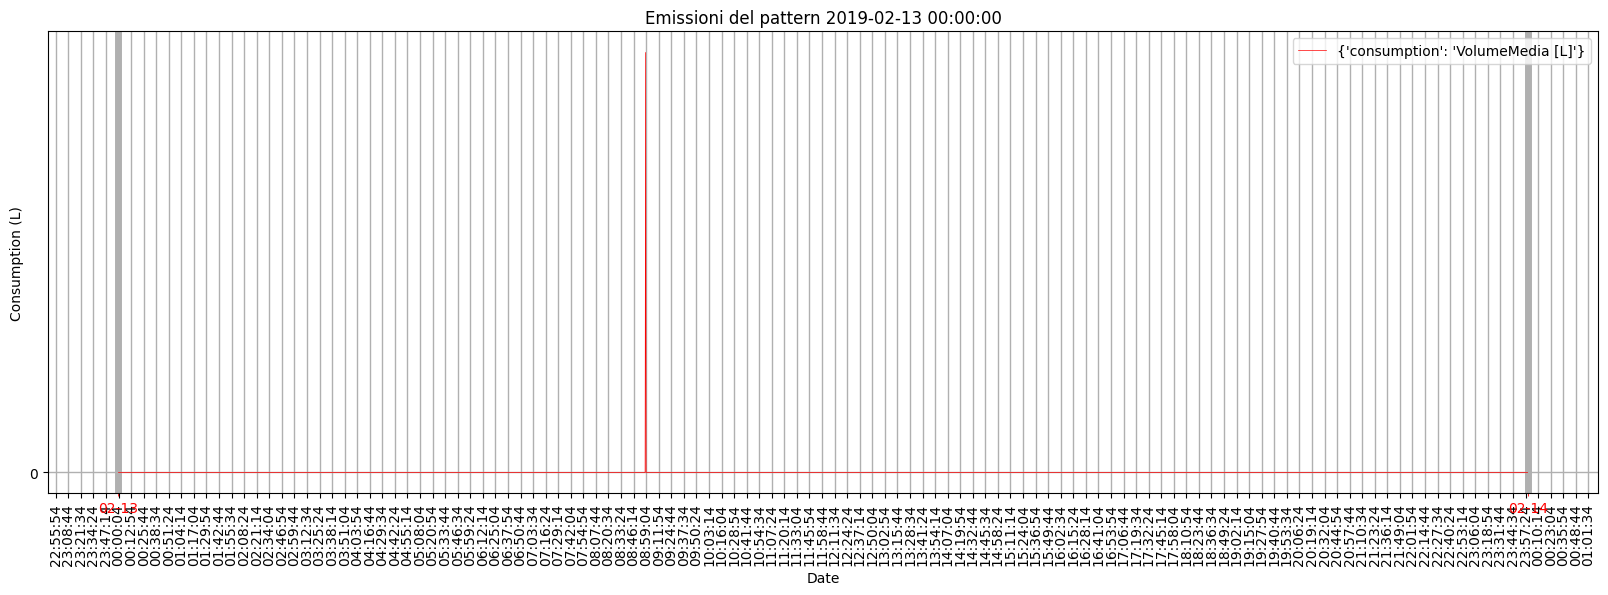

lungo=1 medio=0 piccolo=1



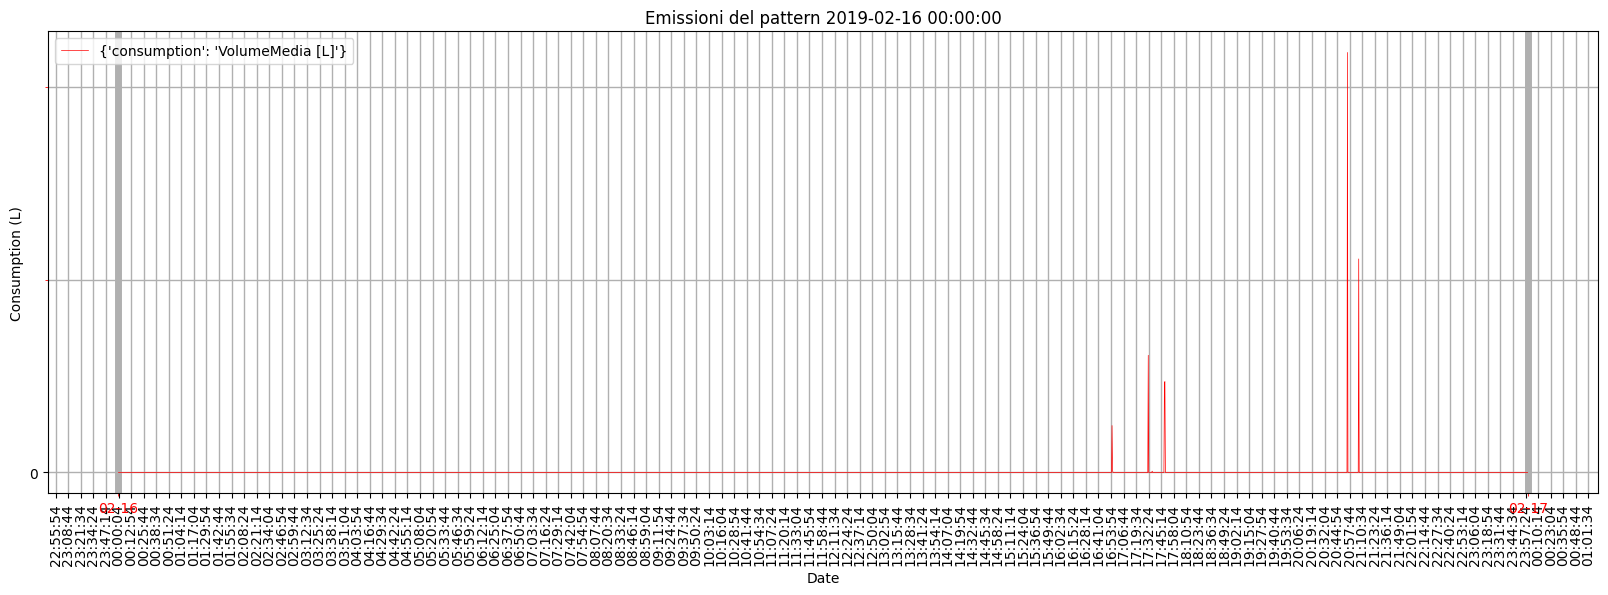

lungo=3 medio=0 piccolo=0



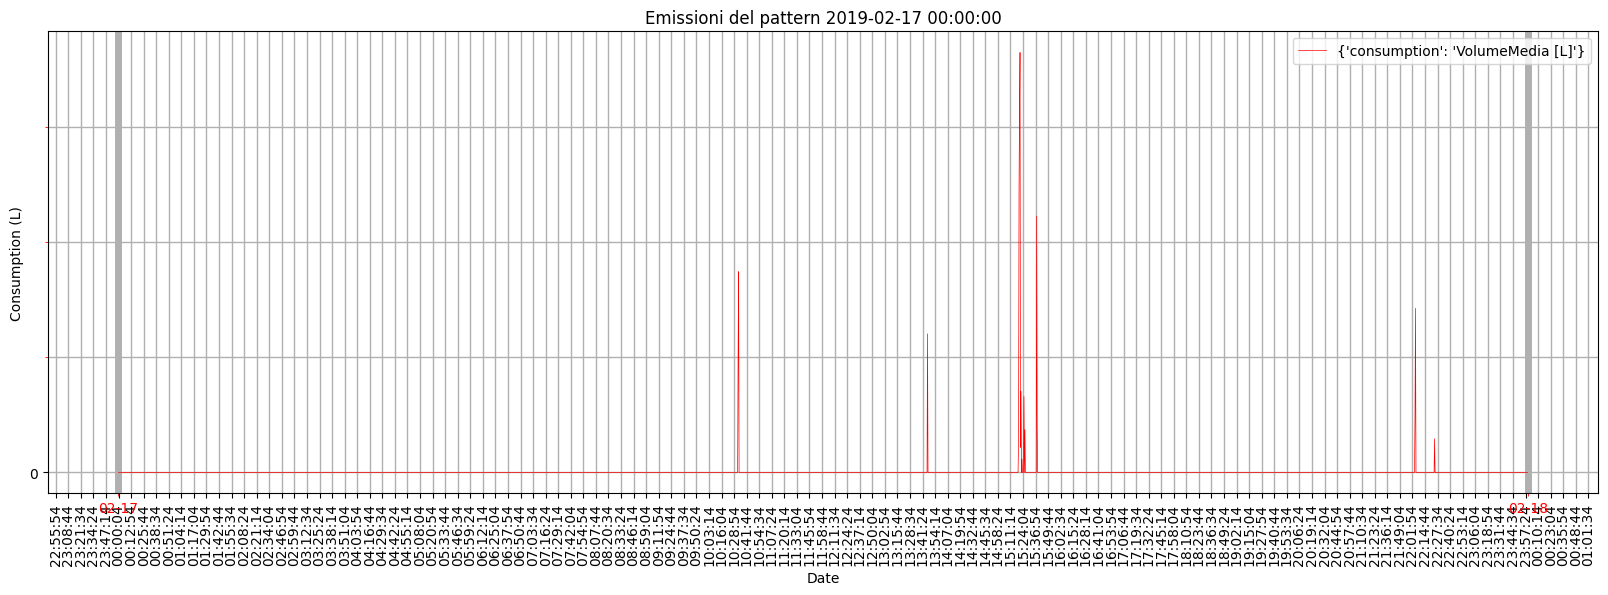

Array con i pattern della settimana 2019-02-11 00:00:00 da LUN a DOM [5]
['0', '0', 'CAMALA1P_S0', '0', '0', 'CCMDLB3PMM_S2f', 'CHMHLH4_S0']
[    0.     0.   177.     0.     0.  3064. 12306.]

Array con i pattern della settimana 2019-02-18 00:00:00 da LUN a DOM [6]
['CGMHLF3MPP_S0', 'CHMHLG2LM_S0', 'CHMHLH8_S2c', 'CFMHLE5_S1a', 'CHMHLH9_S2a', 'CGMHLE5_S0', 'CFMGLD3MPP_S2f']
[ 8773. 11962. 23821.  7761. 15156.  8121.  6905.]

Array con i pattern della settimana 2019-02-25 00:00:00 da LUN a DOM [7]
['CHMHLG5_S1a', 'CHMHLH8_M1c', 'CGMHLE3LMP_S0', 'CHMHLH6_M1d', 'CEMHLE4_S2a', 'CDMHLD5_S1f', 'CFMHLF5_S2a']
[11985. 16848.  8369. 14887.  7887.  6313.  9871.]

Array con i pattern della settimana 2019-03-04 00:00:00 da LUN a DOM [8]
['CFMHLF2MP_S0', 'CDMGLD3PPL_S0', 'CCMDLC3MMP_S2a', 'CCMDLC1M_S0', '0', '0', 'CDMFLC3PPL_P1c']
[9307. 5967. 3804. 3830.    0.    0. 5226.]

Array con i pattern della settimana 2019-03-11 00:00:00 da LUN a DOM [9]
['CFMHLF7_S2f', 'CAMBLA2PP_P1a', 'CEMGLD3MPP_S2f', '

In [41]:
df_dispositivo_sec=read_fixture_sec('Washbasin')
df_dispositivo_emissioni=read_fixture('Washbasin')


#CALCOLI DELLA MEDIA MENSILE, TRIMESTRALE, SEMESTRALE
mm_array=calcola_media_mensile(df_dispositivo_emissioni)
mt_array=calcola_media_trimestrale(df_dispositivo_emissioni)
ms_array=calcola_media_semestrale(df_dispositivo_emissioni)
ma=df_dispositivo_emissioni['consumption'].mean()
#DEBUG 
#print(f'Media MENSILE: {mm_array}\n')
#print(f'Media TRIMESTRALE: {mt_array}\n')
#print(f'Media SEMESTRALE: {ms_array}\n')
#print(f'Media ANNUALE: {ma}\n')

ciclo_pattern_settimane_precise_medie_tre(df_dispositivo_emissioni,df_dispositivo_sec,mm_array,mt_array,ms_array,ma)